Using random forest regressor instead of the linear regressor in ML3.3.8

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla_summer, uif_summer = in_out('af_summer', 'wf_summer')  #first snapshot of data (0002-00172), summer

In [4]:
sla_fall, uif_fall = in_out('af_fall', 'wf_fall') #(0002-00352), fall

In [5]:
sla_winter, uif_winter = in_out('af_winter', 'wf_winter') #(0002-00352), winter 

In [6]:
sla_spring, uif_spring = in_out('af_spring', 'wf_spring') #(0002-00652), spring 

In [99]:
sla_test_set, uif_test_set = in_out("af_test", "wf_test") #(0002-00472), testing on this as well to check if overfit

In [7]:
uif_train = np.concatenate((uif_summer, uif_fall, uif_winter, uif_spring), axis=0) #total uif for training

In [8]:
sla_train = np.concatenate((sla_summer, sla_fall, sla_winter, sla_spring), axis=0) #total sla for training

In [9]:
from sklearn.model_selection import train_test_split
sla_train, sla_test, uif_train, uif_test = train_test_split(sla_train, uif_train, test_size=0.999, random_state=42)

In [10]:
uif_train.shape

(2270, 52)

# Predicting Summer:

In [12]:
from sklearn.ensemble import RandomForestRegressor
rfr1 = RandomForestRegressor()
rfr1.fit(sla_train,uif_train)
uif_lin = rfr1.predict(sla_summer)  
uif_out = uif_summer

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.157848718401849

In [14]:
np.min(uif_out)

17.541994

In [15]:
np.max(uif_out)

339.41235

In [16]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

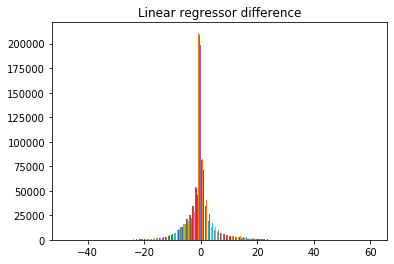

In [17]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [18]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [19]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

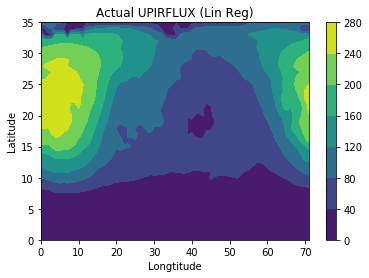

In [20]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

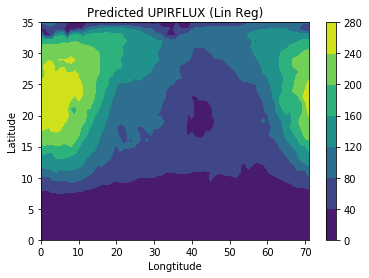

In [21]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

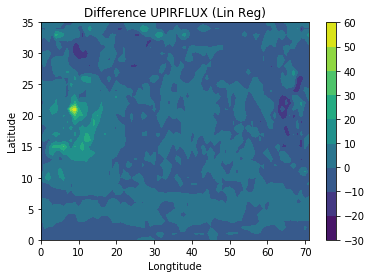

In [22]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

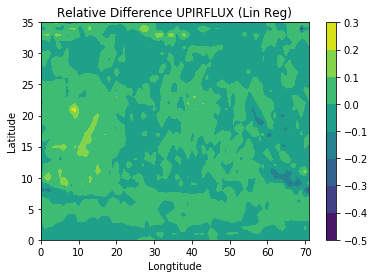

In [23]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [24]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [25]:
real_out.shape

(36, 72)

In [26]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [27]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.28780172,  0.33509995,  0.34618262, ..., -0.34107985,
         0.09554098,  0.21381564],
       [ 0.28779016,  0.33509414,  0.34616364, ..., -0.34110271,
         0.0955328 ,  0.21381389],
       [ 0.2877821 ,  0.33509004,  0.34614966, ..., -0.34111909,
         0.09552698,  0.21381274],
       ...,
       [ 1.02187512,  0.82750865,  0.99993003, ...,  0.21087949,
         0.69149441,  0.55461076],
       [ 1.030689  ,  0.8156056 ,  1.00346239, ...,  0.20911624,
         0.69725243,  0.5452282 ],
       [ 1.0255171 ,  0.78651984,  0.99955272, ...,  0.20812475,
         0.69171793,  0.52186475]])

In [28]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.40078988, 0.40078527, 0.40078199, 0.40072976, 0.4006529 ,
       0.40054782, 0.40015638, 0.39982236, 0.39971814, 0.39971444,
       0.39970931, 0.39946626, 0.3990271 , 0.39828254, 0.39707633,
       0.39534584, 0.39324074, 0.39074592, 0.38751778, 0.3827619 ,
       0.37732797, 0.37440072, 0.37652533, 0.38527643, 0.40039426,
       0.42028301, 0.43915554, 0.4505879 , 0.45523594, 0.45636313,
       0.45598237, 0.45096692, 0.43971641, 0.42979227, 0.45745265,
       0.53790338, 0.64353306, 0.74837181, 0.83741069, 0.87372937,
       0.91160264, 0.93435164, 0.95700917, 0.98041172, 1.00581812,
       1.02467628, 1.0447464 , 1.06456312, 1.08320986, 1.09863583,
       1.10556562, 1.09731291])

In [29]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.43004667, -0.43006647, -0.43008067, -0.43017525, -0.4304674 ,
       -0.43087948, -0.4310929 , -0.43092944, -0.43074398, -0.43098413,
       -0.43158394, -0.43207822, -0.4323882 , -0.43282348, -0.43381098,
       -0.4355477 , -0.43780248, -0.4404296 , -0.44341875, -0.44659851,
       -0.44919566, -0.44984326, -0.44631782, -0.43698816, -0.42178346,
       -0.40169688, -0.38173157, -0.36602491, -0.35275062, -0.33997288,
       -0.33054012, -0.32868043, -0.3334397 , -0.33625542, -0.31379397,
       -0.25107108, -0.16853688, -0.0830687 , -0.01028504,  0.01855601,
        0.04797409,  0.06588938,  0.08350398,  0.09987295,  0.11341472,
        0.12034555,  0.12531082,  0.12713381,  0.12400042,  0.11769986,
        0.11420663,  0.11342735])

In [30]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.20481299, 0.2048186 , 0.20482259, 0.20485919, 0.20493984,
       0.20496926, 0.20496682, 0.2048451 , 0.20468958, 0.20465588,
       0.20479567, 0.20494657, 0.20497091, 0.20487541, 0.20476053,
       0.20473121, 0.20478494, 0.20481034, 0.20466057, 0.204102  ,
       0.20319377, 0.20240313, 0.20194297, 0.20183962, 0.20177423,
       0.20134818, 0.20040176, 0.19856452, 0.19575053, 0.19225516,
       0.18905369, 0.18624824, 0.18395628, 0.18265966, 0.18218825,
       0.18320951, 0.18529453, 0.18774125, 0.18965919, 0.18997651,
       0.19038074, 0.19076627, 0.19148594, 0.19278011, 0.1950137 ,
       0.19730546, 0.2003071 , 0.20394488, 0.20842548, 0.21291754,
       0.21516549, 0.21417493])

In [31]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.13543783, 0.13542416, 0.13541429, 0.13535568, 0.13517029,
       0.13490191, 0.1346941 , 0.13448507, 0.13423668, 0.13399441,
       0.1338788 , 0.13371882, 0.13334082, 0.13263103, 0.13152006,
       0.12992578, 0.12790974, 0.12536269, 0.12200666, 0.11763607,
       0.11319792, 0.11095483, 0.11349009, 0.12250251, 0.13743626,
       0.1566976 , 0.17553431, 0.18930083, 0.19869437, 0.20592543,
       0.21055953, 0.20815965, 0.1991525 , 0.19291849, 0.21353641,
       0.2781358 , 0.36435064, 0.45569701, 0.53409811, 0.56432958,
       0.59533929, 0.61453797, 0.63437557, 0.65435565, 0.67338857,
       0.68542361, 0.69648777, 0.70498236, 0.70965834, 0.71063105,
       0.70825819, 0.69685347])

In [32]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.29742324235781814


# Predicting Fall:

In [33]:
uif_lin = rfr1.predict(sla_fall) 
uif_out = uif_fall

In [34]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

6.351745583616352

In [35]:
np.min(uif_out)

15.713927

In [36]:
np.max(uif_out)

484.24545

In [37]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

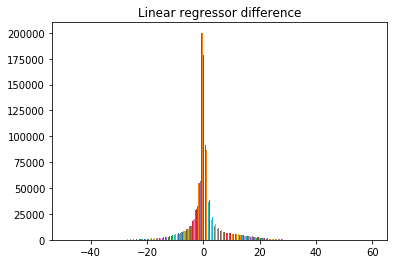

In [38]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [39]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [40]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

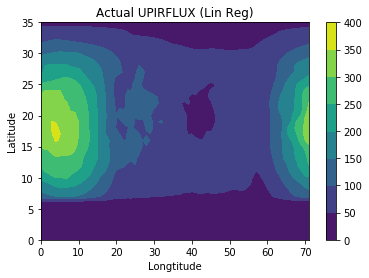

In [41]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

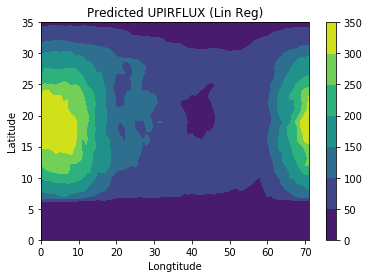

In [42]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

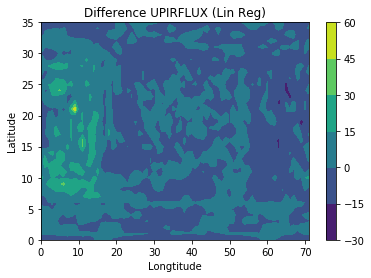

In [43]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

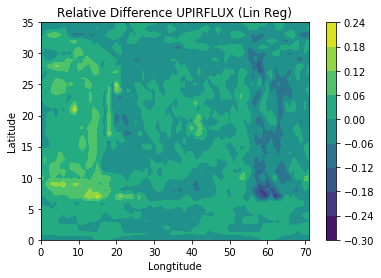

In [44]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [45]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [46]:
real_out.shape

(36, 72)

In [47]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [48]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.39076718,  0.70964785,  0.72959199, ...,  0.24259135,
         0.50760701,  0.71769412],
       [ 0.39077171,  0.70964563,  0.72960454, ...,  0.24259194,
         0.50761099,  0.71770304],
       [ 0.3907752 ,  0.7096441 ,  0.72961457, ...,  0.24259233,
         0.50761421,  0.71770976],
       ...,
       [ 0.01839663,  0.05356225,  0.08580545, ..., -0.04989369,
         0.30219616,  0.12674869],
       [ 0.02506098,  0.0635447 ,  0.10432177, ..., -0.01571087,
         0.3029651 ,  0.12800662],
       [ 0.06353649,  0.05805927,  0.15476203, ...,  0.03972779,
         0.33515297,  0.1103241 ]])

In [49]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.98091574, 0.9809287 , 0.98093826, 0.98112218, 0.98135643,
       0.98126693, 0.98133871, 0.98150854, 0.98158687, 0.98089717,
       0.98011479, 0.97943641, 0.97881758, 0.97834404, 0.97833812,
       0.97874757, 0.97926796, 0.97961203, 0.97934362, 0.97799555,
       0.97476874, 0.96836414, 0.95710446, 0.938793  , 0.91332397,
       0.88156856, 0.8454063 , 0.80391763, 0.75706447, 0.70459861,
       0.64589981, 0.58621401, 0.53398571, 0.49923775, 0.48711702,
       0.47385465, 0.4384584 , 0.3909719 , 0.35288459, 0.34246552,
       0.33478669, 0.33191302, 0.33072518, 0.33040662, 0.32865789,
       0.32535691, 0.32079103, 0.31522345, 0.31098859, 0.31634904,
       0.34720116, 0.40789477])

In [50]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.10434544, -0.10434237, -0.10433989, -0.10438468, -0.1044419 ,
       -0.10443262, -0.10439738, -0.10458608, -0.10478934, -0.10441276,
       -0.10376865, -0.10370862, -0.10433074, -0.10512913, -0.1057505 ,
       -0.10617353, -0.10612639, -0.10522893, -0.10380457, -0.10273055,
       -0.10342167, -0.10763986, -0.11681895, -0.13248317, -0.15459045,
       -0.18352809, -0.21745952, -0.25581485, -0.29807788, -0.34526898,
       -0.39483515, -0.44512697, -0.49434573, -0.53244901, -0.55419861,
       -0.56861709, -0.56102695, -0.5309628 , -0.51678411, -0.51110088,
       -0.50571861, -0.50310935, -0.50123539, -0.50114476, -0.50428627,
       -0.50878322, -0.51427984, -0.51852097, -0.51813343, -0.5067379 ,
       -0.47078085, -0.41055181])

In [51]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.29762203, 0.29762584, 0.29762876, 0.29770994, 0.29781432,
       0.2977671 , 0.29774796, 0.29785163, 0.29792846, 0.29754388,
       0.29701181, 0.29682604, 0.29698055, 0.29711791, 0.29715932,
       0.2972003 , 0.29713612, 0.29681177, 0.29623334, 0.29549659,
       0.29465977, 0.29388013, 0.29324574, 0.29249183, 0.29127999,
       0.28978475, 0.28784626, 0.28512005, 0.28140346, 0.27690943,
       0.27062397, 0.26403316, 0.25993348, 0.25850581, 0.25903108,
       0.25847563, 0.24805459, 0.22938284, 0.21443706, 0.20968932,
       0.2059811 , 0.20455787, 0.20395341, 0.20418042, 0.20517625,
       0.20618514, 0.20723765, 0.20757173, 0.20625812, 0.20281494,
       0.19791511, 0.19724285])

In [52]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.51886636, 0.51887041, 0.51887362, 0.51892322, 0.51895315,
       0.51878062, 0.51877598, 0.51888678, 0.5190567 , 0.51920601,
       0.51918662, 0.51883522, 0.51854272, 0.51832766, 0.51804858,
       0.51782668, 0.51802902, 0.51875308, 0.51939786, 0.51903605,
       0.51653832, 0.51075963, 0.50035562, 0.48322038, 0.45856749,
       0.42649057, 0.38933684, 0.34784814, 0.30230072, 0.25251627,
       0.20001576, 0.14858092, 0.10254638, 0.06811836, 0.04733452,
       0.02760866, 0.01092312, 0.0068559 , 0.00687886, 0.00866357,
       0.01150772, 0.01368775, 0.01650087, 0.01955381, 0.02180389,
       0.02249829, 0.02286964, 0.02262259, 0.02260391, 0.0272316 ,
       0.04510796, 0.08004725])

In [53]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.29839753124651747


# Predicting Winter:

In [54]:
uif_lin = rfr1.predict(sla_winter)  
uif_out = uif_winter

In [55]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.798779228059909

In [56]:
np.min(uif_out)

15.832658

In [57]:
np.max(uif_out)

485.98044

In [58]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

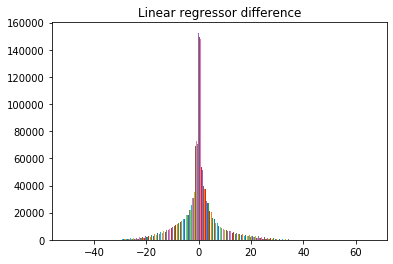

In [59]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [60]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [61]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

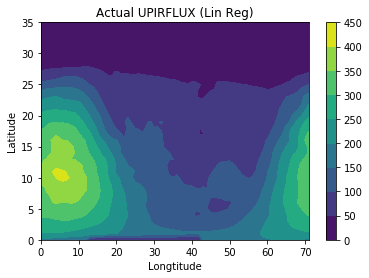

In [62]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

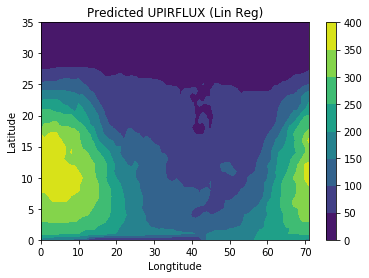

In [63]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

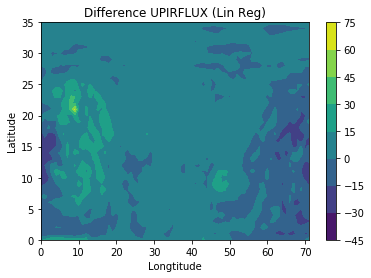

In [64]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

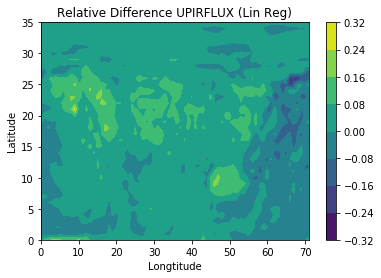

In [65]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [66]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [67]:
real_out.shape

(36, 72)

In [68]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [69]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[1.82821136, 2.71242756, 2.466263  , ..., 1.36620582, 1.16619908,
        1.62226071],
       [1.82817268, 2.71239286, 2.46621887, ..., 1.36618778, 1.16617539,
        1.62221467],
       [1.82814477, 2.71236682, 2.46618675, ..., 1.36617372, 1.1661569 ,
        1.62217974],
       ...,
       [2.65400098, 2.99869871, 2.92523693, ..., 1.91247232, 1.65626032,
        1.51486034],
       [2.63058234, 2.95912602, 2.88505996, ..., 1.91243336, 1.65609191,
        1.49793352],
       [2.59613815, 2.87428331, 2.83706541, ..., 1.91910917, 1.66507752,
        1.44331905]])

In [70]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([2.71242756, 2.71239286, 2.71236682, 2.7122499 , 2.71199067,
       2.71199553, 2.71098866, 2.70891726, 2.70715345, 2.70702513,
       2.70851523, 2.71175755, 2.71744386, 2.72547769, 2.73454977,
       2.74255479, 2.74988031, 2.75868681, 2.76822582, 2.77777845,
       2.78841407, 2.8018735 , 2.82241148, 2.85544629, 2.9005592 ,
       2.95476133, 3.0151918 , 3.08127993, 3.14852719, 3.20888391,
       3.26487408, 3.32259556, 3.38347786, 3.43625193, 3.45869058,
       3.41815764, 3.30946454, 3.20781799, 3.15358237, 3.12859711,
       3.10789616, 3.0960761 , 3.0804234 , 3.06028709, 3.03782567,
       3.02306833, 3.02498578, 3.02926699, 3.02130545, 2.99869871,
       2.95912602, 2.87428331])

In [71]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([1.16619908, 1.16617539, 1.1661569 , 1.16582805, 1.16554216,
       1.16603031, 1.16677726, 1.16710289, 1.16729873, 1.16751273,
       1.16756273, 1.16761878, 1.1683655 , 1.17077249, 1.17482983,
       1.17882527, 1.18206924, 1.18605887, 1.19100903, 1.1961829 ,
       1.20533969, 1.22557319, 1.25682427, 1.29237497, 1.32706024,
       1.36458982, 1.40853514, 1.46101419, 1.52076289, 1.58416782,
       1.64868369, 1.71408252, 1.78017785, 1.8405612 , 1.85861968,
       1.80313111, 1.71040166, 1.65481417, 1.63472421, 1.63084861,
       1.6069294 , 1.58651726, 1.56458685, 1.54255692, 1.52514526,
       1.51886133, 1.50982729, 1.49343525, 1.47341901, 1.451376  ,
       1.42754677, 1.40290145])

In [72]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.36431054, 0.36430754, 0.36430551, 0.36432297, 0.36433455,
       0.36429247, 0.3641226 , 0.36381656, 0.36338759, 0.36309142,
       0.3632513 , 0.36402158, 0.36525833, 0.36649746, 0.36722613,
       0.36734181, 0.36737802, 0.36758988, 0.36764396, 0.36747484,
       0.36722185, 0.36667684, 0.36600831, 0.36598275, 0.36714575,
       0.36925765, 0.3716133 , 0.37363183, 0.37484741, 0.37397568,
       0.37125344, 0.36859284, 0.36883827, 0.37017405, 0.36952288,
       0.36619295, 0.3618798 , 0.3609227 , 0.36289616, 0.36280395,
       0.36188831, 0.36062696, 0.35878256, 0.35673888, 0.35532416,
       0.35514668, 0.35548033, 0.35566424, 0.35379476, 0.34923481,
       0.3421259 , 0.32975823])

In [73]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([1.81261626, 1.81257944, 1.81255189, 1.812254  , 1.81183568,
       1.81175419, 1.81179338, 1.81146905, 1.81120503, 1.81166481,
       1.81271839, 1.81429553, 1.81661153, 1.81978009, 1.82424248,
       1.82993732, 1.83616277, 1.84304528, 1.85109302, 1.861428  ,
       1.87549266, 1.89412894, 1.91814635, 1.94846714, 1.98434028,
       2.02754542, 2.07923155, 2.13997234, 2.20618866, 2.27166274,
       2.33552108, 2.40191216, 2.47081459, 2.53217872, 2.55831789,
       2.52451535, 2.44568325, 2.38308402, 2.35382636, 2.34167359,
       2.32800471, 2.31903516, 2.30806901, 2.29471991, 2.28112233,
       2.2737138 , 2.26795991, 2.26159222, 2.24890122, 2.2308093 ,
       2.21083311, 2.17908592])

In [74]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
2.0831843817271403


# Predicting Spring:

In [75]:
uif_lin = rfr1.predict(sla_spring)
uif_out = uif_spring

In [76]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.693480244563716

In [77]:
np.min(uif_out)

15.936197

In [78]:
np.max(uif_out)

414.86307

In [79]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

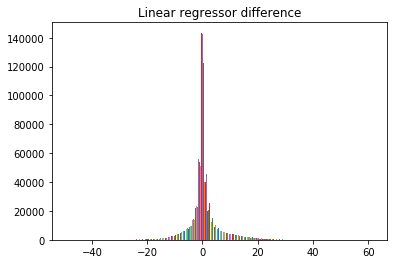

In [80]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [81]:
uif_out.reshape(-1,1).shape

(21430656, 1)

In [82]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

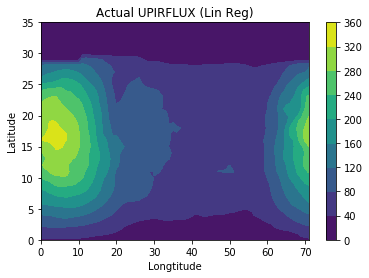

In [83]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

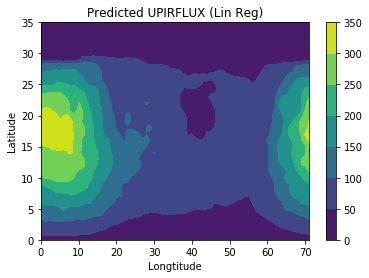

In [84]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

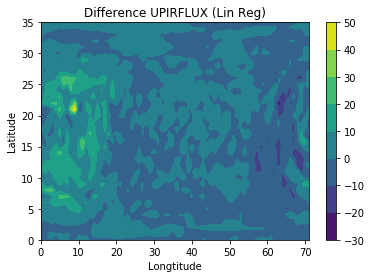

In [85]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

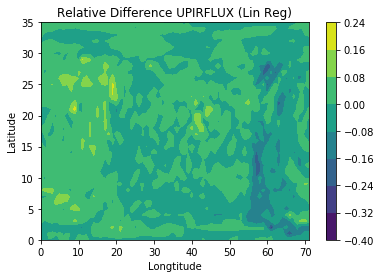

In [86]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [87]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [88]:
real_out.shape

(36, 72)

In [89]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [90]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[0.43690424, 0.76015684, 0.81858463, ..., 0.62242337, 0.5936795 ,
        1.03608689],
       [0.4369081 , 0.76015428, 0.81859147, ..., 0.62242352, 0.5936887 ,
        1.036081  ],
       [0.43691146, 0.76015251, 0.81859651, ..., 0.62242332, 0.59369619,
        1.03607644],
       ...,
       [0.53070773, 0.4051036 , 0.48459062, ..., 0.79022787, 0.8191741 ,
        0.84780452],
       [0.54308288, 0.42101059, 0.50944022, ..., 0.80737473, 0.8210356 ,
        0.85910649],
       [0.56975517, 0.42184819, 0.55864823, ..., 0.83919464, 0.83743374,
        0.85726131]])

In [91]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([1.11897283, 1.11897784, 1.1189818 , 1.11909825, 1.11928975,
       1.11926476, 1.11924681, 1.1192646 , 1.11871952, 1.11806089,
       1.11754192, 1.11697457, 1.11647274, 1.11608252, 1.11581215,
       1.11543422, 1.11452006, 1.11273013, 1.11069994, 1.10942784,
       1.10936577, 1.10956903, 1.10811235, 1.10297492, 1.09285822,
       1.07876643, 1.06308134, 1.04791348, 1.03172469, 1.01036389,
       0.98567181, 0.96317608, 0.94466291, 0.93817559, 0.94849385,
       0.95972588, 0.95225127, 0.94426262, 0.9443825 , 0.94595397,
       0.95508611, 0.96323091, 0.97454928, 0.98907153, 1.00537977,
       1.01593477, 1.02501447, 1.0309215 , 1.03205622, 1.03050763,
       1.0406275 , 1.08303627])

In [92]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([0.25487945, 0.25488594, 0.25489146, 0.25496719, 0.25506129,
       0.25471361, 0.25429664, 0.25410477, 0.25447466, 0.2548896 ,
       0.25442842, 0.25392398, 0.25402441, 0.25434693, 0.25421105,
       0.2532197 , 0.25146321, 0.24933446, 0.24751234, 0.24645789,
       0.24660747, 0.2479393 , 0.24850495, 0.24486201, 0.23337392,
       0.21745572, 0.19991555, 0.1840856 , 0.16759499, 0.14614477,
       0.12614009, 0.11871008, 0.11502875, 0.11209859, 0.11039386,
       0.10852552, 0.10162847, 0.1394653 , 0.19876725, 0.22095136,
       0.2445082 , 0.25960738, 0.274281  , 0.28164928, 0.28305371,
       0.28280425, 0.28338969, 0.28314947, 0.27593773, 0.27252124,
       0.28987976, 0.33343569])

In [93]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.24578815, 0.24578753, 0.24578699, 0.24581369, 0.24586016,
       0.24594389, 0.24609994, 0.2462001 , 0.24589873, 0.24534878,
       0.24509815, 0.24510135, 0.24514316, 0.24512617, 0.24516645,
       0.24536575, 0.2455704 , 0.24553588, 0.24519719, 0.24461853,
       0.24388604, 0.2430593 , 0.24232953, 0.24169191, 0.24095728,
       0.2401243 , 0.23891887, 0.23687015, 0.23421422, 0.23079323,
       0.22584527, 0.21838831, 0.21019931, 0.20618459, 0.20736672,
       0.20818099, 0.20117215, 0.18759478, 0.17646645, 0.17270212,
       0.16947994, 0.16810564, 0.16737119, 0.16737005, 0.16800909,
       0.16862608, 0.16889386, 0.16827036, 0.16659622, 0.16416029,
       0.16285943, 0.16893308])

In [94]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.70741649, 0.70741947, 0.70742186, 0.7074878 , 0.7075656 ,
       0.70739555, 0.70727098, 0.70708924, 0.70683137, 0.70659765,
       0.70637611, 0.70612956, 0.70591584, 0.70563956, 0.7052078 ,
       0.7043932 , 0.7030173 , 0.70124469, 0.69969167, 0.69882035,
       0.69879214, 0.69881066, 0.69664253, 0.68990197, 0.67766712,
       0.66100642, 0.64238371, 0.62449468, 0.60588171, 0.58267604,
       0.55816341, 0.54029454, 0.52958774, 0.52433248, 0.52261384,
       0.51713381, 0.50800968, 0.52005301, 0.54504036, 0.55692613,
       0.57114446, 0.58125263, 0.59248775, 0.60399654, 0.61434612,
       0.62000721, 0.62462692, 0.62791337, 0.63079842, 0.63722207,
       0.65517044, 0.68465598])

In [95]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.6433262691388584


# Last test set:

In [101]:
uif_lin = rfr1.predict(sla_test_set)
uif_out = uif_test_set

In [102]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

11.683549430610471

In [103]:
np.min(uif_out)

16.084946

In [104]:
np.max(uif_out)

489.8716

In [105]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

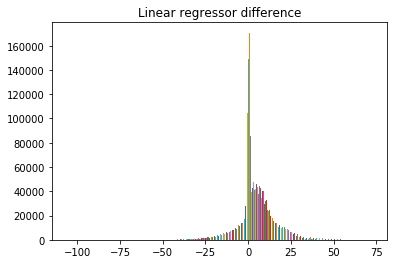

In [106]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [107]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [108]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

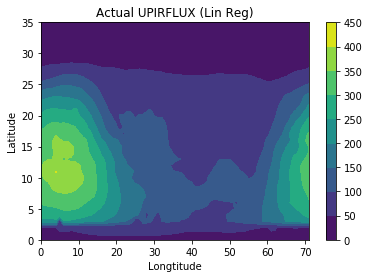

In [109]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

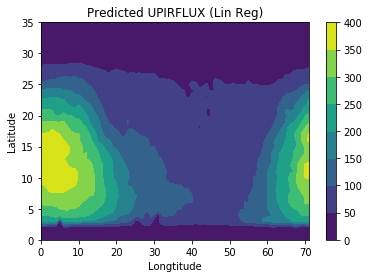

In [110]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

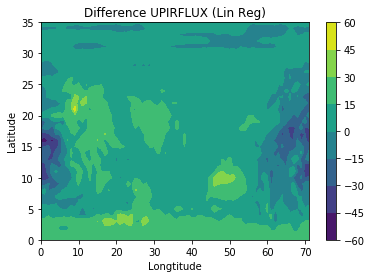

In [111]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

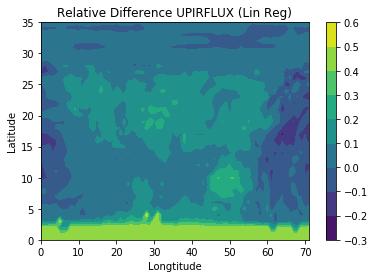

In [112]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [113]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [114]:
real_out.shape

(36, 72)

In [115]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [116]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[4.79113657, 5.62527099, 5.26687788, ..., 4.11638609, 4.56236367,
        5.41600036],
       [4.79113768, 5.62525818, 5.26686261, ..., 4.11633727, 4.56228458,
        5.41595346],
       [4.79113723, 5.62524618, 5.26684973, ..., 4.11630217, 4.56222626,
        5.41591976],
       ...,
       [7.30545915, 6.97807943, 7.23492047, ..., 5.64598356, 6.67036171,
        6.53389063],
       [7.20431499, 6.8568055 , 7.11564388, ..., 5.57021732, 6.61231209,
        6.41762715],
       [7.08887096, 6.67670011, 6.99996978, ..., 5.47233799, 6.52231359,
        6.23726711]])

In [117]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([5.81237957, 5.81233774, 5.81230431, 5.81194167, 5.81152069,
       5.81211179, 5.81352331, 5.81532894, 5.81707765, 5.81907426,
       5.82124911, 5.82370902, 5.82680028, 5.83113586, 5.83890197,
       5.85267743, 5.87302474, 5.89707601, 5.9178887 , 5.93507539,
       5.95623534, 5.98344079, 6.01872862, 6.06740286, 6.13788337,
       6.23183346, 6.34891826, 6.47762556, 6.60160353, 6.71011354,
       6.80835015, 6.90045851, 6.99755501, 7.10829653, 7.22153507,
       7.32045498, 7.37459589, 7.43499499, 7.51012458, 7.52291328,
       7.5329866 , 7.55433348, 7.57218367, 7.5840628 , 7.59023505,
       7.59385219, 7.59532925, 7.58799396, 7.55591945, 7.49395922,
       7.40530374, 7.29143684])

In [118]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([4.11638609, 4.11633727, 4.11630217, 4.11596378, 4.11530594,
       4.11447749, 4.11363232, 4.11256286, 4.11213833, 4.11378489,
       4.11783269, 4.12462774, 4.13480425, 4.14734645, 4.15995053,
       4.17204517, 4.184257  , 4.1973874 , 4.21265392, 4.2331073 ,
       4.26166784, 4.29954803, 4.34852965, 4.40948434, 4.47706214,
       4.55336162, 4.64505166, 4.75456396, 4.86991251, 4.97934121,
       5.09731779, 5.23206812, 5.37035467, 5.4971776 , 5.60749871,
       5.71540872, 5.79501832, 5.85454252, 5.89648897, 5.89803638,
       5.89131638, 5.88293105, 5.86702167, 5.842247  , 5.81178576,
       5.79244111, 5.77689798, 5.7581086 , 5.71479709, 5.64598356,
       5.57021732, 5.47233799])

In [119]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.45509948, 0.45509882, 0.45509778, 0.45511724, 0.45518056,
       0.45539375, 0.45574729, 0.45621907, 0.4565536 , 0.45655527,
       0.45617045, 0.45541715, 0.45436835, 0.45324962, 0.45252409,
       0.45254334, 0.45309527, 0.45370505, 0.45435333, 0.45489733,
       0.45464746, 0.45302983, 0.44927189, 0.44427046, 0.44159385,
       0.44312306, 0.44664499, 0.44850444, 0.44789482, 0.44433336,
       0.43554572, 0.42141952, 0.41003187, 0.40884295, 0.41226138,
       0.4064632 , 0.39517826, 0.38970323, 0.39082557, 0.39329916,
       0.39801183, 0.40240375, 0.40839194, 0.41587229, 0.42430187,
       0.43021091, 0.43546223, 0.43946626, 0.4431721 , 0.4463756 ,
       0.44596827, 0.44581191])

In [120]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([5.00990717, 5.00987975, 5.00985864, 5.00956624, 5.00921913,
       5.00947812, 5.01000935, 5.01060987, 5.01153155, 5.01341811,
       5.01609622, 5.01975923, 5.02539698, 5.03362644, 5.04457661,
       5.05802288, 5.07346207, 5.09107281, 5.11047382, 5.13233324,
       5.15776979, 5.18921923, 5.23208144, 5.2905934 , 5.36359246,
       5.45305689, 5.56187496, 5.6873317 , 5.81608548, 5.93815769,
       6.06065231, 6.18490776, 6.31299133, 6.45070449, 6.58678508,
       6.70853365, 6.7981162 , 6.88544048, 6.95633394, 6.9708528 ,
       6.97793742, 6.97846242, 6.97354945, 6.96252394, 6.94789624,
       6.93968224, 6.93264451, 6.91758819, 6.87249282, 6.79410087,
       6.69225115, 6.56511717])

In [121]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
5.843608187113508
